In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 40.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install ThymeBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
import rpy2.robjects as robjects
from rpy2.robjects import r
import rpy2.robjects.numpy2ri as numpy2ri
from rpy2.robjects.packages import importr
from datetime import datetime
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis
from ThymeBoost import ThymeBoost as tb
from statistics import mean

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Traffic Flow Analysis/Đồ án DS304/Dataset/Dataset.csv', index_col = 0)
data = data.reset_index()
for i in range(len(data)):
  data['Datetime'][i] = datetime.strptime(data['Datetime'][i], '%d/%m/%Y %H:%M')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime').asfreq('60T')
data.head(5)

station0  station1    station2    station3    station4  \
Datetime                                                                        
2013-03-01 00:00:00   286.00000     917.0  728.000000  604.000000  108.000000   
2013-03-01 01:00:00   140.84322     506.0  408.773251  380.782758   64.055779   
2013-03-01 02:00:00   123.33451     385.0  322.000000  280.815809   40.471014   
2013-03-01 03:00:00   315.33451     529.0  371.830464  328.000000   68.902591   
2013-03-01 04:00:00  1127.33451    1281.0  581.000000  726.000000  241.828590   

                       station5    station6    station7    station8  rain  \
Datetime                                                                    
2013-03-01 00:00:00  204.000000  532.000000  713.000000  815.000000   0.0   
2013-03-01 01:00:00  106.803239  370.000000  384.956179  467.105533   0.0   
2013-03-01 02:00:00   85.677942  255.682071  301.000000  361.000000   0.0   
2013-03-01 03:00:00  102.924045  286.000000  372.000000  421.872219   0.0   
2013-03-01 04:00:00  138.533604  626.889384  905.000000  949.000000   0.0   

                     ...  dewpt  rhum  vappr     msl  wdsp  wddir  sun    vis  \
Datetime             ...                                                        
2013-03-01 00:00:00  ...    4.0   8.1     97  1033.6     6     30  0.0   9000   
2013-03-01 01:00:00  ...    4.6   8.5     98  1033.3     7     30  0.0   7000   
2013-03-01 02:00:00  ...    4.7   8.5     97  1033.2     5     10  0.0   9000   
2013-03-01 03:00:00  ...    4.5   8.4     97  1033.0     4     20  0.0   9000   
2013-03-01 04:00:00  ...    4.5   8.4     95  1032.8     5     10  0.0  12000   

                     clht  clamt  
Datetime                          
2013-03-01 00:00:00   250      5  
2013-03-01 01:00:00    37      7  
2013-03-01 02:00:00    37      7  
2013-03-01 03:00:00    33      7  
2013-03-01 04:00:00    34      7  

[5 rows x 22 columns]

In [ ]:
# Train and test set split
nobs = 8760
columns = data.columns
train, test = data[0:-nobs], data[-nobs:]
print(train.shape)
print(test.shape)

(70128, 22)
(8760, 22)


## Outliers Detections

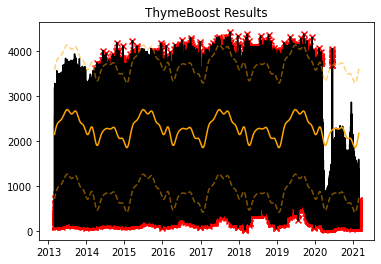

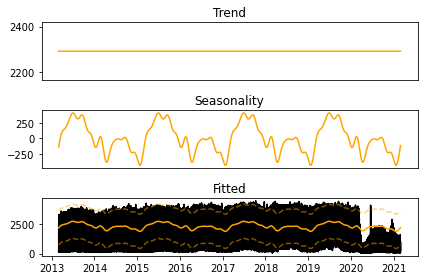

In [ ]:
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(train['station0'], trend_estimator='mean', seasonal_estimator='fourier', seasonal_period = 365*48, 
                                        global_cost='maicc', fit_type='global')
                                       
boosted_model.plot_results(output)
boosted_model.plot_components(output)

In [ ]:
def fit_outliers(col):
  boosted_model = tb.ThymeBoost()
  output = boosted_model.detect_outliers(train[col], trend_estimator='mean', seasonal_estimator='fourier', seasonal_period = 365*48, 
                                          global_cost='maicc', fit_type='global')
  for i in range(len(train[col])):
    if (output['outliers'][i] == True):
      train[col][i] = output['yhat'][i]

In [ ]:
for col in columns:
  fit_outliers(col)

Text(0.5, 1.0, 'Hourly traffic flow at station0 after fitting outliers')

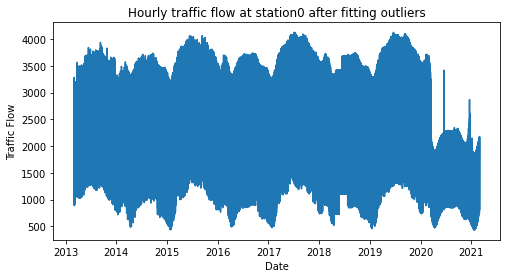

In [ ]:
plt.figure(figsize = (8, 4))
plt.plot(train['station0'])
plt.xlabel('Date')
plt.ylabel('Traffic Flow')
plt.title('Hourly traffic flow at station0 after fitting outliers')

## Stationary check

In [ ]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
  r = adfuller(series, autolag = 'AIC')
  output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 10), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
  p_value = output['pvalue']
  def adjust(val, length = 6): return str(val).ljust(length)

  print(f'  Augmented Dickey-Fuller Test on "{name}"', "\n  ", '-'*47)
  print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
  print(f' Significance Level = {signif}')
  print(f' Test Statistic     = {output["test_statistic"]}')
  print(f' No. Lags Chosen    = {output["n_lags"]}')

  for key, val in r[4].items():
    print(f' Critical value {adjust(key)} = {round(val, 3)}')

  if p_value <= signif:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null hypothesis")
    print(f" => Series is Non-Stationary.")

In [ ]:
for column in columns:
  adfuller_test(train[column], name = column)

  Augmented Dickey-Fuller Test on "station0" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic     = -10.4389
 No. Lags Chosen    = 62
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary.
  Augmented Dickey-Fuller Test on "station1" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic     = -13.614
 No. Lags Chosen    = 62
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary.
  Augmented Dickey-Fuller Test on "station2" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic     = -

In [ ]:
def plot_stationarity(y, lags):
   
    y = pd.Series(y)

    # decompose the time series into trend, seasonality and residuals
    decomp = sm.tsa.seasonal_decompose(y)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))

    y.plot(ax=ax1)
    ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title("Temperature")

    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")

    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);

    plt.tight_layout()

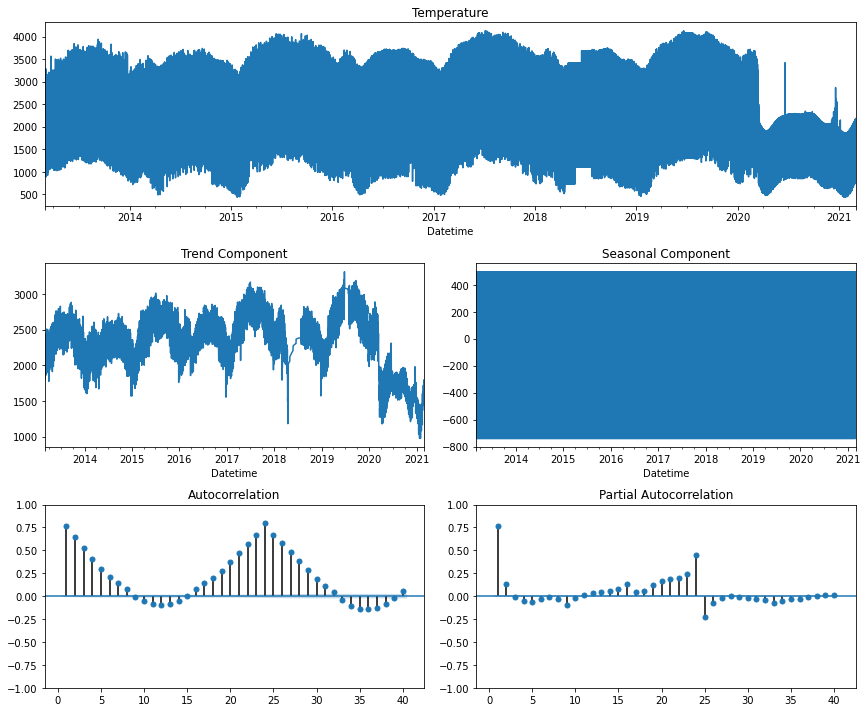

In [ ]:
plot_stationarity(train['station0'], 40)

## Causality check

In [ ]:
max_lag = 24
def causation_matrix(data, variables, test='ssr_ftest', verbose=False):
  X = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in X.columns:
    for r in X.index:
      test_result = grangercausalitytests(data[[r, c]], maxlag = max_lag, verbose = False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(max_lag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      X.loc[r, c] = min_p_value
  X.columns = [var + '-x axis' for var in variables]
  X.index = [var + '-y axis' for var in variables]
  return X

In [ ]:
granger_causation_mt = causation_matrix(train, variables = columns)

In [ ]:
granger_causation_mt.iloc[:, 0:9]

station0-x axis  station1-x axis  station2-x axis  \
station0-y axis           1.0000           0.0000           0.0000   
station1-y axis           0.0000           1.0000           0.0000   
station2-y axis           0.0000           0.0000           1.0000   
station3-y axis           0.0000           0.0000           0.0000   
station4-y axis           0.0000           0.0000           0.0000   
station5-y axis           0.0000           0.0000           0.0000   
station6-y axis           0.0000           0.0000           0.0000   
station7-y axis           0.0000           0.0000           0.0000   
station8-y axis           0.0000           0.0000           0.0000   
rain-y axis               0.0018           0.0090           0.0063   
temp-y axis               0.0000           0.0000           0.0000   
wetb-y axis               0.0000           0.0000           0.0000   
dewpt-y axis              0.0000           0.0000           0.0000   
rhum-y axis               0.0000           0.0000           0.0000   
vappr-y axis              0.0000           0.0000           0.0000   
msl-y axis                0.0016           0.0307           0.0256   
wdsp-y axis               0.0000           0.0000           0.0000   
wddir-y axis              0.0000           0.0000           0.0000   
sun-y axis                0.0000           0.0000           0.0000   
vis-y axis                0.0000           0.0000           0.0000   
clht-y axis               0.0000           0.0000           0.0000   
clamt-y axis              0.0000           0.0000           0.0000   

                 station3-x axis  station4-x axis  station5-x axis  \
station0-y axis           0.0000           0.0000           0.0000   
station1-y axis           0.0000           0.0000           0.0000   
station2-y axis           0.0000           0.0000           0.0000   
station3-y axis           1.0000           0.0000           0.0000   
station4-y axis           0.0000           1.0000           0.0000   
station5-y axis           0.0000           0.0000           1.0000   
station6-y axis           0.0000           0.0000           0.0000   
station7-y axis           0.0000           0.0000           0.0000   
station8-y axis           0.0000           0.0000           0.0000   
rain-y axis               0.0090           0.0202           0.0001   
temp-y axis               0.0000           0.0000           0.0000   
wetb-y axis               0.0000           0.0000           0.0000   
dewpt-y axis              0.0000           0.0000           0.0000   
rhum-y axis               0.0000           0.0000           0.0000   
vappr-y axis              0.0000           0.0000           0.0000   
msl-y axis                0.0632           0.0511           0.1052   
wdsp-y axis               0.0000           0.0000           0.0000   
wddir-y axis              0.0000           0.0000           0.0000   
sun-y axis                0.0000           0.0000           0.0000   
vis-y axis                0.0000           0.0000           0.0000   
clht-y axis               0.0000           0.0000           0.0000   
clamt-y axis              0.0000           0.0000           0.0000   

                 station6-x axis  station7-x axis  station8-x axis  
station0-y axis           0.0000           0.0000           0.0000  
station1-y axis           0.0000           0.0000           0.0000  
station2-y axis           0.0000           0.0000           0.0000  
station3-y axis           0.0000           0.0000           0.0000  
station4-y axis           0.0000           0.0000           0.0000  
station5-y axis           0.0000           0.0000           0.0000  
station6-y axis           1.0000           0.0000           0.0000  
station7-y axis           0.0000           1.0000           0.0000  
station8-y axis           0.0000           0.0000           1.0000  
rain-y axis               0.0141           0.0035           0.0043  
temp-y axis               0.0000    

In [ ]:
granger_causation_mt.iloc[:, 9:22]

rain-x axis  temp-x axis  wetb-x axis  dewpt-x axis  \
station0-y axis       0.0009          0.0          0.0           0.0   
station1-y axis       0.0289          0.0          0.0           0.0   
station2-y axis       0.0088          0.0          0.0           0.0   
station3-y axis       0.0667          0.0          0.0           0.0   
station4-y axis       0.0066          0.0          0.0           0.0   
station5-y axis       0.0031          0.0          0.0           0.0   
station6-y axis       0.0050          0.0          0.0           0.0   
station7-y axis       0.0019          0.0          0.0           0.0   
station8-y axis       0.0142          0.0          0.0           0.0   
rain-y axis           1.0000          0.0          0.0           0.0   
temp-y axis           0.0000          1.0          0.0           0.0   
wetb-y axis           0.0000          0.0          1.0           0.0   
dewpt-y axis          0.0000          0.0          0.0           1.0   
rhum-y axis           0.0000          0.0          0.0           0.0   
vappr-y axis          0.0000          0.0          0.0           0.0   
msl-y axis            0.0000          0.0          0.0           0.0   
wdsp-y axis           0.0000          0.0          0.0           0.0   
wddir-y axis          0.0000          0.0          0.0           0.0   
sun-y axis            0.0000          0.0          0.0           0.0   
vis-y axis            0.0000          0.0          0.0           0.0   
clht-y axis           0.0000          0.0          0.0           0.0   
clamt-y axis          0.0000          0.0          0.0           0.0   

                 rhum-x axis  vappr-x axis  msl-x axis  wdsp-x axis  \
station0-y axis          0.0        0.0000      0.0557       0.0000   
station1-y axis          0.0        0.0000      0.0017       0.0000   
station2-y axis          0.0        0.0000      0.0205       0.0000   
station3-y axis          0.0        0.0000      0.0008       0.0000   
station4-y axis          0.0        0.0000      0.2725       0.0000   
station5-y axis          0.0        0.0000      0.0311       0.0000   
station6-y axis          0.0        0.0000      0.0187       0.0000   
station7-y axis          0.0        0.0000      0.0934       0.0000   
station8-y axis          0.0        0.0000      0.0995       0.0000   
rain-y axis              0.0        0.0000      0.0000       0.0000   
temp-y axis              0.0        0.0000      0.0000       0.0000   
wetb-y axis              0.0        0.0000      0.0000       0.0000   
dewpt-y axis             0.0        0.0000      0.0000       0.0000   
rhum-y axis              1.0        0.0000      0.0000       0.0000   
vappr-y axis             0.0        1.0000      0.0000       0.0000   
msl-y axis               0.0        0.0067      1.0000       0.0000   
wdsp-y axis              0.0        0.0000      0.0000       1.0000   
wddir-y axis             0.0        0.0000      0.0000       0.0000   
sun-y axis               0.0        0.0000      0.0000       0.0000   
vis-y axis               0.0        0.0000      0.0000       0.0000   
clht-y axis              0.0        0.0000      0.0000       0.0000   
clamt-y axis             0.0        0.0000      0.0000       0.0004   

                 wddir-x axis  sun-x axis  vis-x axis  clht-x axis  \
station0-y axis           0.0         0.0         0.0          0.0   
station1-y axis           0.0         0.0         0.0          0.0   
station2-y axis           0.0         0.0         0.0          0.0   
station3-y axis           0.0         0.0         0.0          0.0   
station4-y axis           0.0         0.0         0.0          0.0   
station5-y axis           0.0         0.0         0.0          0.0   
station6-y axis           0.0         0.0         0.0          0.0   
station7-y axis           0.0         0.0         0.0          0.0   
station8-y axis           0.0         0.0         0.0          0.0   
rain-y axis               

## Training VAR Model

In [ ]:
#train = train.drop(['rain', 'msl'], axis = 1)
#train.shape

In [ ]:
var_model = VAR(train)
res = var_model.select_order(maxlags=12)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        155.5       155.5   3.481e+67       155.5
1        139.2       139.3   2.888e+60       139.2
2        138.7       138.9   1.763e+60       138.8
3        138.6       138.7   1.489e+60       138.6
4        138.4       138.7   1.305e+60       138.5
5        138.3       138.6   1.188e+60       138.4
6        138.2       138.6   1.057e+60       138.3
7        138.1       138.5   9.471e+59       138.2
8        138.0       138.5   8.550e+59       138.2
9        137.9       138.5   7.807e+59       138.1
10       137.8       138.5   7.137e+59       138.0
11       137.8       138.5   6.692e+59       138.0
12      137.7*      138.4*  6.266e+59*      137.9*
--------------------------------------------------


In [ ]:
fitted_model = var_model.fit(12)
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jul, 2022
Time:                     11:34:48
--------------------------------------------------------------------
No. of Equations:         22.0000    BIC:                    138.449
Nobs:                     70116.0    HQIC:                   137.923
Log likelihood:      -7.01001e+06    FPE:                6.26606e+59
AIC:                      137.688    Det(Omega_mle):     5.76703e+59
--------------------------------------------------------------------
Results for equation station0
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              899.352233       251.352947            3.578           0.000
L1.station0          0.537622         0.004190          128.317           0.000
L1.station1          0.008246         0.001672            4.9

## Residuals Test

In [ ]:
# Serial Correlation Test
out = durbin_watson(fitted_model.resid)

def adjust(val, length = 6): 
  return str(val).ljust(length)
for col, val in zip(train.columns, out):
  print(adjust(col), ':', round(val, 2))

station0 : 1.86
station1 : 1.87
station2 : 1.88
station3 : 1.86
station4 : 1.92
station5 : 1.95
station6 : 1.92
station7 : 1.86
station8 : 1.86
rain   : 2.0
temp   : 2.0
wetb   : 2.0
dewpt  : 2.0
rhum   : 2.0
vappr  : 2.0
msl    : 2.0
wdsp   : 2.0
wddir  : 2.0
sun    : 2.0
vis    : 2.0
clht   : 2.0
clamt  : 2.0


In [ ]:
residuals = fitted_model.resid.values.reshape(1, -1).tolist()[0]
fitted_values = fitted_model.fittedvalues.values.reshape(1, -1).tolist()[0]

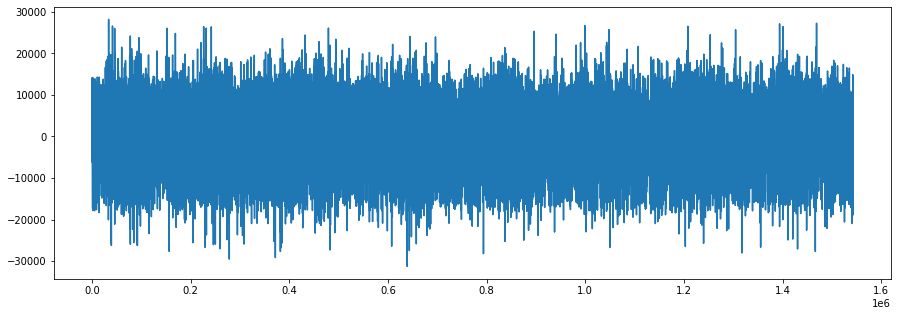

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(residuals)

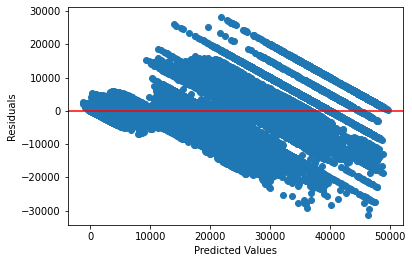

In [ ]:
plt.scatter(fitted_values, residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [ ]:
# Normality Test
normality_test = fitted_model.test_normality()
normality_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
import math
root = fitted_model.roots
real = root.real
imaginary = root.imag
modulus = abs(root)
ar_root = {'Real':real, 'Imaginary':imaginary, 'Modulus':modulus}
ar_root = pd.DataFrame(ar_root)
ar_root

Real  Imaginary   Modulus
0   -3.089683  -0.000000  3.089683
1    1.594567  -2.527699  2.988629
2    1.594567   2.527699  2.988629
3    2.437945  -0.000000  2.437945
4    2.029477  -0.000000  2.029477
..        ...        ...       ...
259  1.037125  -0.000000  1.037125
260  1.029049  -0.000000  1.029049
261  0.979850   0.263645  1.014699
262  0.979850  -0.263645  1.014699
263  1.006233  -0.000000  1.006233

[264 rows x 3 columns]

In [ ]:
ar_root[:50]

Real  Imaginary   Modulus
0  -3.089683  -0.000000  3.089683
1   1.594567  -2.527699  2.988629
2   1.594567   2.527699  2.988629
3   2.437945  -0.000000  2.437945
4   2.029477  -0.000000  2.029477
5   0.897145   1.710130  1.931169
6   0.897145  -1.710130  1.931169
7  -1.066999   1.567876  1.896503
8  -1.066999  -1.567876  1.896503
9  -1.638582   0.953468  1.895799
10 -1.638582  -0.953468  1.895799
11 -0.276852  -1.868865  1.889260
12 -0.276852   1.868865  1.889260
13 -1.860125  -0.000000  1.860125
14  0.393034   1.767167  1.810347
15  0.393034  -1.767167  1.810347
16 -0.628853   1.484631  1.612323
17 -0.628853  -1.484631  1.612323
18  1.190413   1.057213  1.592100
19  1.190413  -1.057213  1.592100
20 -1.553897  -0.000000  1.553897
21 -1.208040  -0.973186  1.551274
22 -1.208040   0.973186  1.551274
23 -1.104366  -1.086880  1.549494
24 -1.104366   1.086880  1.549494
25 -0.946475   1.209413  1.535739
26 -0.946475  -1.209413  1.535739
27 -1.292591   0.795603  1.517819
28 -1.292591  -0.795603  1.517819
29 -0.722329   1.333891  1.516913
30 -0.722329  -1.333891  1.516913
31  1.344583  -0.654196  1.495284
32  1.344583   0.654196  1.495284
33 -1.364355  -0.608218  1.493785
34 -1.364355   0.608218  1.493785
35  0.859146  -1.220771  1.492788
36  0.859146   1.220771  1.492788
37 -0.125726  -1.482217  1.487539
38 -0.125726   1.482217  1.487539
39  1.294706  -0.727690  1.485193
40  1.294706   0.727690  1.485193
41  1.063156   1.030667  1.480734
42  1.063156  -1.030667  1.480734
43  0.784208   1.254553  1.479488
44  0.784208  -1.254553  1.479488
45 -1.336522  -0.624228  1.475111
46 -1.336522   0.624228  1.475111
47 -0.627178   1.334483  1.474516
48 -0.627178  -1.334483  1.474516
49 -1.453766  -0.235312  1.472687

In [ ]:
ar_root[50:100]

Real  Imaginary   Modulus
50 -1.453766   0.235312  1.472687
51 -0.005258  -1.469416  1.469425
52 -0.005258   1.469416  1.469425
53  0.343722   1.426211  1.467046
54  0.343722  -1.426211  1.467046
55 -0.945638  -1.120400  1.466126
56 -0.945638   1.120400  1.466126
57 -1.378800   0.486177  1.462005
58 -1.378800  -0.486177  1.462005
59  0.597487   1.333848  1.461555
60  0.597487  -1.333848  1.461555
61  0.194605  -1.447893  1.460912
62  0.194605   1.447893  1.460912
63 -0.746867   1.246001  1.452697
64 -0.746867  -1.246001  1.452697
65 -0.156308   1.443707  1.452144
66 -0.156308  -1.443707  1.452144
67 -1.158626   0.868686  1.448112
68 -1.158626  -0.868686  1.448112
69 -1.211124   0.792081  1.447140
70 -1.211124  -0.792081  1.447140
71  0.025963  -1.440240  1.440474
72  0.025963   1.440240  1.440474
73 -0.787095  -1.201270  1.436164
74 -0.787095   1.201270  1.436164
75 -0.538180  -1.327952  1.432862
76 -0.538180   1.327952  1.432862
77 -1.378925  -0.360269  1.425212
78 -1.378925   0.360269  1.425212
79 -1.348654   0.454403  1.423148
80 -1.348654  -0.454403  1.423148
81 -1.395410  -0.277415  1.422718
82 -1.395410   0.277415  1.422718
83 -0.793892  -1.178093  1.420622
84 -0.793892   1.178093  1.420622
85  1.420064  -0.000000  1.420064
86  0.323431  -1.379615  1.417020
87  0.323431   1.379615  1.417020
88  0.175409   1.406064  1.416963
89  0.175409  -1.406064  1.416963
90  1.036505  -0.963652  1.415263
91  1.036505   0.963652  1.415263
92  0.040626   1.412583  1.413167
93  0.040626  -1.412583  1.413167
94 -0.288662  -1.382372  1.412189
95 -0.288662   1.382372  1.412189
96 -0.066711   1.410544  1.412121
97 -0.066711  -1.410544  1.412121
98  1.382132  -0.286698  1.411554
99  1.382132   0.286698  1.411554

In [ ]:
ar_root[100:150]

Real  Imaginary   Modulus
100 -1.409495  -0.052836  1.410485
101 -1.409495   0.052836  1.410485
102  0.709974  -1.215138  1.407347
103  0.709974   1.215138  1.407347
104 -1.397570  -0.126985  1.403327
105 -1.397570   0.126985  1.403327
106 -1.261389  -0.596666  1.395390
107 -1.261389   0.596666  1.395390
108 -1.227670  -0.661338  1.394468
109 -1.227670   0.661338  1.394468
110 -0.393392   1.336155  1.392863
111 -0.393392  -1.336155  1.392863
112  0.775365   1.153012  1.389471
113  0.775365  -1.153012  1.389471
114  1.176703   0.738215  1.389097
115  1.176703  -0.738215  1.389097
116  0.882756   1.070435  1.387476
117  0.882756  -1.070435  1.387476
118 -0.605866   1.245897  1.385400
119 -0.605866  -1.245897  1.385400
120 -1.384506  -0.000000  1.384506
121  0.636040   1.225767  1.380960
122  0.636040  -1.225767  1.380960
123 -1.058400  -0.882836  1.378263
124 -1.058400   0.882836  1.378263
125 -0.702411  -1.185056  1.377584
126 -0.702411   1.185056  1.377584
127 -1.164033   0.718094  1.367711
128 -1.164033  -0.718094  1.367711
129 -1.364097   0.002201  1.364098
130 -1.364097  -0.002201  1.364098
131  0.760601   1.132001  1.363796
132  0.760601  -1.132001  1.363796
133 -1.138098  -0.750389  1.363213
134 -1.138098   0.750389  1.363213
135  0.017262   1.363069  1.363179
136  0.017262  -1.363069  1.363179
137  0.263755   1.325961  1.351939
138  0.263755  -1.325961  1.351939
139 -1.199438  -0.623494  1.351812
140 -1.199438   0.623494  1.351812
141  1.256682  -0.487608  1.347965
142  1.256682   0.487608  1.347965
143  1.347139  -0.000000  1.347139
144  1.212829   0.577760  1.343414
145  1.212829  -0.577760  1.343414
146 -0.058308   1.340658  1.341926
147 -0.058308  -1.340658  1.341926
148 -1.341520  -0.000000  1.341520
149 -0.516525  -1.234478  1.338183

In [ ]:
ar_root[150:200]

Real  Imaginary   Modulus
150 -0.516525   1.234478  1.338183
151 -0.786204  -1.082630  1.337986
152 -0.786204   1.082630  1.337986
153  0.561403   1.212206  1.335895
154  0.561403  -1.212206  1.335895
155  0.615488   1.184730  1.335069
156  0.615488  -1.184730  1.335069
157  1.186105   0.603751  1.330924
158  1.186105  -0.603751  1.330924
159  0.722639  -1.115057  1.328743
160  0.722639   1.115057  1.328743
161 -0.635267  -1.166901  1.328617
162 -0.635267   1.166901  1.328617
163  1.156512   0.651288  1.327289
164  1.156512  -0.651288  1.327289
165  0.054749   1.324456  1.325587
166  0.054749  -1.324456  1.325587
167  1.253748   0.419095  1.321940
168  1.253748  -0.419095  1.321940
169 -0.678630   1.126336  1.314980
170 -0.678630  -1.126336  1.314980
171 -1.070280  -0.761422  1.313493
172 -1.070280   0.761422  1.313493
173  1.143372   0.642285  1.311423
174  1.143372  -0.642285  1.311423
175 -0.919573   0.931398  1.308861
176 -0.919573  -0.931398  1.308861
177  0.348079  -1.260441  1.307620
178  0.348079   1.260441  1.307620
179  0.604444  -1.159421  1.307520
180  0.604444   1.159421  1.307520
181 -0.244302  -1.273032  1.296262
182 -0.244302   1.273032  1.296262
183  0.709536  -1.078416  1.290900
184  0.709536   1.078416  1.290900
185  0.179961  -1.277018  1.289636
186  0.179961   1.277018  1.289636
187  1.270808   0.189301  1.284830
188  1.270808  -0.189301  1.284830
189 -0.348930   1.235594  1.283918
190 -0.348930  -1.235594  1.283918
191 -1.194269  -0.407612  1.261914
192 -1.194269   0.407612  1.261914
193  0.854769  -0.918458  1.254669
194  0.854769   0.918458  1.254669
195  1.224493   0.266872  1.253238
196  1.224493  -0.266872  1.253238
197  1.207746  -0.326284  1.251044
198  1.207746   0.326284  1.251044
199 -1.121062   0.554566  1.250730

In [ ]:
ar_root[200:250]

Real  Imaginary   Modulus
200 -1.121062  -0.554566  1.250730
201  1.101822  -0.585239  1.247605
202  1.101822   0.585239  1.247605
203  1.237229  -0.000000  1.237229
204  1.060750   0.626114  1.231750
205  1.060750  -0.626114  1.231750
206 -1.230665  -0.013119  1.230735
207 -1.230665   0.013119  1.230735
208  1.042894  -0.647191  1.227389
209  1.042894   0.647191  1.227389
210  1.225052  -0.000000  1.225052
211 -1.188432  -0.289648  1.223220
212 -1.188432   0.289648  1.223220
213  1.101023   0.522524  1.218722
214  1.101023  -0.522524  1.218722
215  0.862140   0.859742  1.217556
216  0.862140  -0.859742  1.217556
217 -0.598447  -1.050172  1.208718
218 -0.598447   1.050172  1.208718
219  0.947163   0.740451  1.202242
220  0.947163  -0.740451  1.202242
221  0.011231   1.194724  1.194776
222  0.011231  -1.194724  1.194776
223  0.569329  -1.034683  1.180976
224  0.569329   1.034683  1.180976
225  1.169910  -0.000000  1.169910
226 -1.007017   0.589182  1.166713
227 -1.007017  -0.589182  1.166713
228  1.014484  -0.575497  1.166351
229  1.014484   0.575497  1.166351
230  1.158730  -0.000000  1.158730
231  0.328734   1.108692  1.156401
232  0.328734  -1.108692  1.156401
233 -0.818170  -0.814689  1.154608
234 -0.818170   0.814689  1.154608
235  1.110469  -0.293636  1.148635
236  1.110469   0.293636  1.148635
237  0.797111  -0.821050  1.144338
238  0.797111   0.821050  1.144338
239 -0.273277   1.108694  1.141877
240 -0.273277  -1.108694  1.141877
241  1.132841  -0.010767  1.132892
242  1.132841   0.010767  1.132892
243 -0.582323   0.965877  1.127838
244 -0.582323  -0.965877  1.127838
245 -1.084097   0.281135  1.119956
246 -1.084097  -0.281135  1.119956
247  1.113048  -0.000000  1.113048
248  0.571655  -0.948539  1.107482
249  0.571655   0.948539  1.107482

In [ ]:
ar_root[250:]

Real  Imaginary   Modulus
250  1.107335  -0.014873  1.107435
251  1.107335   0.014873  1.107435
252  0.965649   0.540303  1.106529
253  0.965649  -0.540303  1.106529
254  1.096823  -0.000000  1.096823
255  0.004152   1.091936  1.091944
256  0.004152  -1.091936  1.091944
257  1.079613  -0.000000  1.079613
258  1.054454  -0.000000  1.054454
259  1.037125  -0.000000  1.037125
260  1.029049  -0.000000  1.029049
261  0.979850   0.263645  1.014699
262  0.979850  -0.263645  1.014699
263  1.006233  -0.000000  1.006233

## Tuning Models

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'p': [12, 24, 36, 48], 'tr': ['c','ct','ctt','n']}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_pg = pd.DataFrame(columns=['p', 'tr', 'RMSE'])
print('starting grid search')
for a,b in enumerate(pg):
    p = b.get('p')
    tr = b.get('tr')
    model = VAR(train).fit(p, trend = tr)
    lag_order = model.k_ar
    forecast_input = train.values[-lag_order:]
    z = model.forecast(y=forecast_input, steps = nobs)
    df_pred = pd.DataFrame(z, index = train.index[lag_order:(lag_order + nobs)], columns = train.columns)
    rmse = np.sqrt(mean_squared_error(train[lag_order:(lag_order + nobs)], df_pred))
    df_pg = df_pg.append({'p': p, 'tr': tr,'RMSE': rmse}, ignore_index=True)

starting grid search


In [ ]:
df_pg

p   tr         RMSE
0   12    c  2082.754689
1   12   ct  2119.132058
2   12  ctt  2164.114792
3   12    n  2085.325052
4   24    c  2074.482953
5   24   ct  2119.634724
6   24  ctt  2162.918502
7   24    n  2079.763811
8   36    c  2080.472917
9   36   ct  2126.561514
10  36  ctt  2172.092041
11  36    n  2084.152790
12  48    c  2076.287666
13  48   ct  2126.194496
14  48  ctt  2161.568469
15  48    n  2080.842496

In [ ]:
fitted_model = VAR(train).fit(24, 'c')
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jul, 2022
Time:                     11:38:41
--------------------------------------------------------------------
No. of Equations:         22.0000    BIC:                    136.935
Nobs:                     70104.0    HQIC:                   135.884
Log likelihood:      -6.92334e+06    FPE:                6.45547e+58
AIC:                      135.415    Det(Omega_mle):     5.47143e+58
--------------------------------------------------------------------
Results for equation station0
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              379.562980       227.736389            1.667           0.096
L1.station0          0.345858         0.003778           91.538           0.000
L1.station1          0.012177         0.001458            8.3

## Forecast VAR model

In [ ]:
fc = fitted_model.forecast(train.values, steps=nobs)
forecast = pd.DataFrame(fc, index = test.index, columns = train.columns)
forecast.head(5)

station0     station1     station2     station3  \
Datetime                                                                  
2021-03-01 00:00:00  2171.643742  4160.957454  3990.534289  3177.862657   
2021-03-01 01:00:00  2201.102677  4489.437677  3763.551809  2991.271890   
2021-03-01 02:00:00  2050.155495  4095.161469  3785.314948  3055.333124   
2021-03-01 03:00:00  2128.607103  4650.340303  3629.299300  2872.626929   
2021-03-01 04:00:00  2265.541097  4842.544135  4270.035209  3282.752172   

                       station4    station5     station6     station7  \
Datetime                                                                
2021-03-01 00:00:00  621.008996  232.772643  1656.939935  4860.592357   
2021-03-01 01:00:00  561.386457  227.879302  1616.898756  4749.336061   
2021-03-01 02:00:00  493.179143  185.812997  1615.874381  4192.393469   
2021-03-01 03:00:00  498.402027  246.562923  1676.719961  4357.583917   
2021-03-01 04:00:00  574.016664  404.819404  1888.304923  5217.503587   

                        station8      rain  ...     dewpt      rhum  \
Datetime                                    ...                       
2021-03-01 00:00:00  5204.597459  0.021929  ...  1.261863  6.540419   
2021-03-01 01:00:00  5040.163819  0.022487  ...  1.392340  6.588665   
2021-03-01 02:00:00  4489.605124  0.018127  ...  1.584056  6.654237   
2021-03-01 03:00:00  4549.976127  0.027085  ...  1.726024  6.704804   
2021-03-01 04:00:00  5600.285520  0.026741  ...  1.966671  6.814921   

                         vappr          msl       wdsp       wddir       sun  \
Datetime                                                                       
2021-03-01 00:00:00  93.460710  1010.552320  10.931463  132.270593 -0.016893   
2021-03-01 01:00:00  90.899922  1010.460441  10.886303  141.540702 -0.009008   
2021-03-01 02:00:00  89.502437  1010.555880  10.365021  152.318049 -0.010991   
2021-03-01 03:00:00  88.527390  1010.754850  10.174007  157.448720 -0.004186   
2021-03-01 04:00:00  88.763845  1010.679055  10.441468  159.809838  0.007398   

                              vis        clht     clamt  
Datetime                                                 
2021-03-01 00:00:00  14289.632707  233.658641  5.278033  
2021-03-01 01:00:00  15311.851578  221.090147  5.345485  
2021-03-01 02:00:00  16370.317351  206.499989  5.371116  
2021-03-01 03:00:00  18021.101933  187.278748  5.533907  
2021-03-01 04:00:00  19205.118685  183.392339  5.610966  

[5 rows x 22 columns]

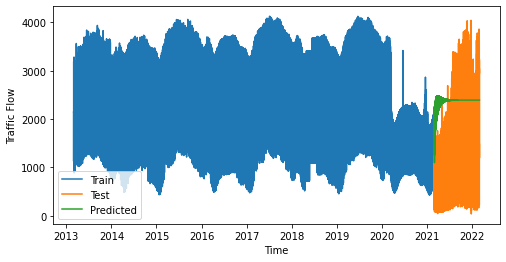

In [ ]:
plt.rcParams["figure.figsize"] = [8,4]
plt.plot( train['station0'], label='Train')
plt.plot(test['station0'], label='Test')
plt.plot(forecast['station0'], label='Predicted')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.show()

In [ ]:
MAE = mean_absolute_error(test, forecast)
MSE = mean_squared_error(test, forecast)
RMSE = mean_squared_error(test, forecast, squared = False)
print('MAE: ', MAE)
print('MSE: ', MSE)
print('RMSE: ', RMSE)

MAE:  1174.5842935482412
MSE:  8641747.899993576
RMSE:  1397.3516431394057


In [ ]:
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))
    mse = np.mean((forecast - actual)**2) 
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mae': mae, 'mse':mse, 'rmse':rmse})
    
for column in train.columns:
  print('Forecast Accuracy of:', column)
  accuracy_prod = forecast_accuracy(np.array(forecast[column]), np.array(test[column]))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: station0
mae    :  1011.4681
mse    :  1460491.129
rmse   :  1208.5078
Forecast Accuracy of: station1
mae    :  2678.2668
mse    :  8762879.5823
rmse   :  2960.2161
Forecast Accuracy of: station2
mae    :  2085.5191
mse    :  5737541.486
rmse   :  2395.3166
Forecast Accuracy of: station3
mae    :  1717.4449
mse    :  3776514.1177
rmse   :  1943.3255
Forecast Accuracy of: station4
mae    :  318.973
mse    :  129608.4654
rmse   :  360.0118
Forecast Accuracy of: station5
mae    :  889.5117
mse    :  1031831.713
rmse   :  1015.7912
Forecast Accuracy of: station6
mae    :  749.7801
mse    :  830315.2332
rmse   :  911.2163
Forecast Accuracy of: station7
mae    :  3275.2367
mse    :  12997880.2759
rmse   :  3605.2573
Forecast Accuracy of: station8
mae    :  3611.8005
mse    :  15720633.7843
rmse   :  3964.9254
Forecast Accuracy of: rain
mae    :  0.0887
mse    :  0.1267
rmse   :  0.356
Forecast Accuracy of: temp
mae    :  3.9826
mse    :  24.1801
rmse   :  4.9173
Forecas

## Residuals Test

In [ ]:
# Serial Correlation Test
out = durbin_watson(fitted_model.resid)

def adjust(val, length = 6): 
  return str(val).ljust(length)
for col, val in zip(train.columns, out):
  print(adjust(col), ':', round(val, 2))

station0 : 1.86
station1 : 1.87
station2 : 1.88
station3 : 1.86
station4 : 1.92
station5 : 1.95
station6 : 1.92
station7 : 1.86
station8 : 1.86
rain   : 2.0
temp   : 2.0
wetb   : 2.0
dewpt  : 2.0
rhum   : 2.0
vappr  : 2.0
msl    : 2.0
wdsp   : 2.0
wddir  : 2.0
sun    : 2.0
vis    : 2.0
clht   : 2.0
clamt  : 2.0


In [ ]:
residuals = fitted_model.resid.values.reshape(1, -1).tolist()[0]
fitted_values = fitted_model.fittedvalues.values.reshape(1, -1).tolist()[0]

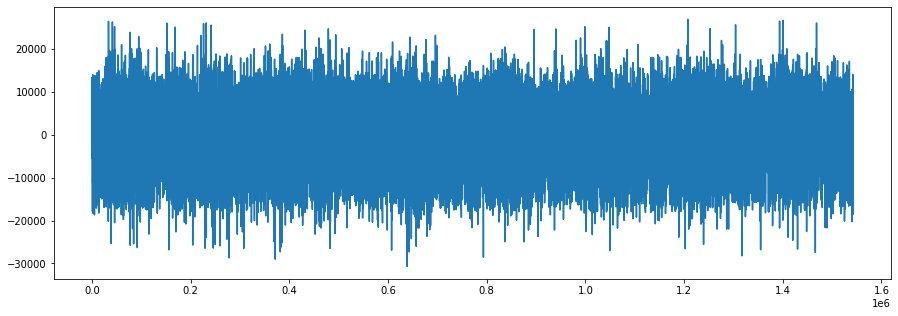

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(residuals)

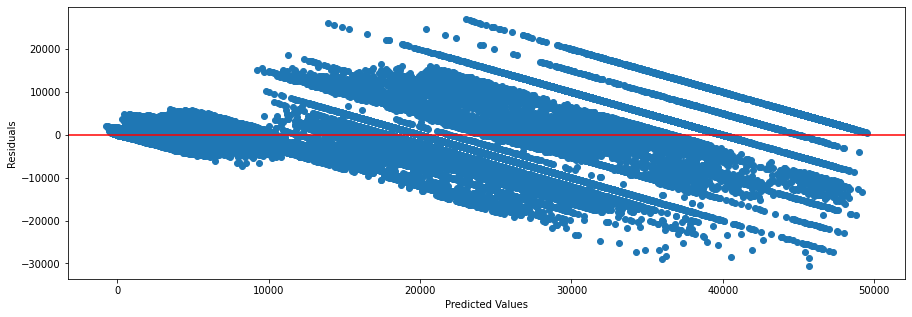

In [ ]:
plt.scatter(fitted_values, residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [ ]:
# Normality Test
normality_test = fitted_model.test_normality()
normality_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
import math
root = fitted_model.roots
real = root.real
imaginary = root.imag
modulus = abs(root)
ar_root = {'Real':real, 'Imaginary':imaginary, 'Modulus':modulus}
ar_root = pd.DataFrame(ar_root)
ar_root

Real  Imaginary   Modulus
0    2.942813  -0.000000  2.942813
1   -2.010873   1.042756  2.265160
2   -2.010873  -1.042756  2.265160
3   -0.698426   2.072039  2.186582
4   -0.698426  -2.072039  2.186582
..        ...        ...       ...
523  0.973830   0.258568  1.007573
524  1.004405  -0.000000  1.004405
525  1.002318  -0.000000  1.002318
526  0.967147   0.259491  1.001354
527  0.967147  -0.259491  1.001354

[528 rows x 3 columns]

In [ ]:
ar_root[:50]

Real  Imaginary   Modulus
0   2.942813  -0.000000  2.942813
1  -2.010873   1.042756  2.265160
2  -2.010873  -1.042756  2.265160
3  -0.698426   2.072039  2.186582
4  -0.698426  -2.072039  2.186582
5   1.481280  -1.586842  2.170774
6   1.481280   1.586842  2.170774
7  -1.442021   1.187448  1.868009
8  -1.442021  -1.187448  1.868009
9  -1.783452  -0.000000  1.783452
10  0.203420  -1.436019  1.450355
11  0.203420   1.436019  1.450355
12 -0.718831  -1.090700  1.306271
13 -0.718831   1.090700  1.306271
14 -0.880145  -0.948063  1.293630
15 -0.880145   0.948063  1.293630
16  1.154392  -0.579994  1.291903
17  1.154392   0.579994  1.291903
18  0.983883   0.797291  1.266372
19  0.983883  -0.797291  1.266372
20 -1.249228   0.184014  1.262708
21 -1.249228  -0.184014  1.262708
22 -1.258958  -0.000000  1.258958
23 -0.499983  -1.147765  1.251937
24 -0.499983   1.147765  1.251937
25 -0.346576   1.198305  1.247417
26 -0.346576  -1.198305  1.247417
27 -1.237737  -0.129656  1.244509
28 -1.237737   0.129656  1.244509
29 -0.298104   1.207105  1.243370
30 -0.298104  -1.207105  1.243370
31  0.228466   1.221492  1.242674
32  0.228466  -1.221492  1.242674
33  0.337658   1.186299  1.233417
34  0.337658  -1.186299  1.233417
35  1.186294  -0.333617  1.232312
36  1.186294   0.333617  1.232312
37  0.896539   0.844417  1.231594
38  0.896539  -0.844417  1.231594
39 -0.902526   0.836216  1.230370
40 -0.902526  -0.836216  1.230370
41 -1.007361   0.706023  1.230140
42 -1.007361  -0.706023  1.230140
43 -1.048088   0.641863  1.229014
44 -1.048088  -0.641863  1.229014
45 -0.152160   1.217214  1.226688
46 -0.152160  -1.217214  1.226688
47 -1.077745   0.584966  1.226263
48 -1.077745  -0.584966  1.226263
49 -0.888445  -0.844522  1.225786

In [ ]:
ar_root[50:100]

Real  Imaginary   Modulus
50 -0.888445   0.844522  1.225786
51 -1.199145  -0.249328  1.224791
52 -1.199145   0.249328  1.224791
53 -0.580291  -1.078001  1.224264
54 -0.580291   1.078001  1.224264
55  0.578736   1.071704  1.217984
56  0.578736  -1.071704  1.217984
57 -1.148891  -0.401893  1.217156
58 -1.148891   0.401893  1.217156
59 -1.139466  -0.414674  1.212575
60 -1.139466   0.414674  1.212575
61  0.747182   0.953345  1.211258
62  0.747182  -0.953345  1.211258
63  0.076661   1.208503  1.210932
64  0.076661  -1.208503  1.210932
65  0.655253   1.017252  1.210024
66  0.655253  -1.017252  1.210024
67 -1.173419   0.294260  1.209752
68 -1.173419  -0.294260  1.209752
69  0.953239   0.740353  1.206975
70  0.953239  -0.740353  1.206975
71 -0.823946   0.881783  1.206826
72 -0.823946  -0.881783  1.206826
73 -0.979397  -0.702181  1.205104
74 -0.979397   0.702181  1.205104
75  0.721939  -0.964129  1.204467
76  0.721939   0.964129  1.204467
77 -0.538490  -1.076694  1.203845
78 -0.538490   1.076694  1.203845
79 -0.282588  -1.168197  1.201891
80 -0.282588   1.168197  1.201891
81  0.841780   0.857775  1.201820
82  0.841780  -0.857775  1.201820
83  0.392153  -1.135649  1.201450
84  0.392153   1.135649  1.201450
85  0.899130   0.796559  1.201225
86  0.899130  -0.796559  1.201225
87  0.785339   0.908454  1.200852
88  0.785339  -0.908454  1.200852
89  0.495936   1.093159  1.200395
90  0.495936  -1.093159  1.200395
91 -0.766012   0.923866  1.200126
92 -0.766012  -0.923866  1.200126
93 -0.684001  -0.981585  1.196397
94 -0.684001   0.981585  1.196397
95  0.542362   1.066345  1.196348
96  0.542362  -1.066345  1.196348
97 -0.010622   1.196208  1.196255
98 -0.010622  -1.196208  1.196255
99 -1.059230   0.554011  1.195365

In [ ]:
ar_root[100:150]

Real  Imaginary   Modulus
100 -1.059230  -0.554011  1.195365
101  0.130148   1.187510  1.194620
102  0.130148  -1.187510  1.194620
103 -1.083890   0.500905  1.194037
104 -1.083890  -0.500905  1.194037
105 -0.086591   1.190609  1.193754
106 -0.086591  -1.190609  1.193754
107 -0.840446   0.847603  1.193641
108 -0.840446  -0.847603  1.193641
109 -0.236184   1.169730  1.193336
110 -0.236184  -1.169730  1.193336
111 -0.253109  -1.165547  1.192713
112 -0.253109   1.165547  1.192713
113 -0.373191  -1.131760  1.191702
114 -0.373191   1.131760  1.191702
115  0.062452   1.188879  1.190518
116  0.062452  -1.188879  1.190518
117  0.993307   0.656171  1.190471
118  0.993307  -0.656171  1.190471
119 -1.190239  -0.016496  1.190353
120 -1.190239   0.016496  1.190353
121 -0.936679   0.734403  1.190258
122 -0.936679  -0.734403  1.190258
123 -1.186106   0.089702  1.189493
124 -1.186106  -0.089702  1.189493
125 -0.958167   0.704772  1.189448
126 -0.958167  -0.704772  1.189448
127  0.299625  -1.150946  1.189308
128  0.299625   1.150946  1.189308
129 -0.609787   1.017755  1.186451
130 -0.609787  -1.017755  1.186451
131 -0.327744   1.140050  1.186225
132 -0.327744  -1.140050  1.186225
133  1.056455   0.539436  1.186207
134  1.056455  -0.539436  1.186207
135  1.039129   0.570141  1.185264
136  1.039129  -0.570141  1.185264
137 -1.164027   0.216658  1.184018
138 -1.164027  -0.216658  1.184018
139 -0.035417  -1.182707  1.183237
140 -0.035417   1.182707  1.183237
141 -1.170779   0.162826  1.182047
142 -1.170779  -0.162826  1.182047
143  0.198255   1.164943  1.181693
144  0.198255  -1.164943  1.181693
145  0.084957   1.178550  1.181608
146  0.084957  -1.178550  1.181608
147 -0.150029   1.171113  1.180684
148 -0.150029  -1.171113  1.180684
149  1.109464   0.402954  1.180374

In [ ]:
ar_root[150:200]

Real  Imaginary   Modulus
150  1.109464  -0.402954  1.180374
151 -0.566808   1.035124  1.180149
152 -0.566808  -1.035124  1.180149
153  0.267104  -1.148832  1.179474
154  0.267104   1.148832  1.179474
155 -1.178277  -0.045387  1.179151
156 -1.178277   0.045387  1.179151
157 -1.005759   0.615234  1.179010
158 -1.005759  -0.615234  1.179010
159 -0.016766   1.178845  1.178965
160 -0.016766  -1.178845  1.178965
161 -1.124979   0.351335  1.178564
162 -1.124979  -0.351335  1.178564
163 -1.037788   0.558484  1.178520
164 -1.037788  -0.558484  1.178520
165  0.354178  -1.121711  1.176298
166  0.354178   1.121711  1.176298
167 -0.879473   0.780419  1.175809
168 -0.879473  -0.780419  1.175809
169  0.640599   0.985918  1.175755
170  0.640599  -0.985918  1.175755
171  0.598387  -1.011245  1.175025
172  0.598387   1.011245  1.175025
173  0.430031  -1.093348  1.174877
174  0.430031   1.093348  1.174877
175  0.801084   0.859160  1.174688
176  0.801084  -0.859160  1.174688
177 -1.077977  -0.465587  1.174226
178 -1.077977   0.465587  1.174226
179  0.336079   1.125010  1.174137
180  0.336079  -1.125010  1.174137
181 -1.125140   0.334087  1.173692
182 -1.125140  -0.334087  1.173692
183  0.548993  -1.036669  1.173062
184  0.548993   1.036669  1.173062
185  0.999368   0.613652  1.172734
186  0.999368  -0.613652  1.172734
187  1.152328  -0.214956  1.172206
188  1.152328   0.214956  1.172206
189 -0.063375  -1.170293  1.172008
190 -0.063375   1.170293  1.172008
191 -0.985839  -0.632531  1.171314
192 -0.985839   0.632531  1.171314
193 -0.395421  -1.101799  1.170606
194 -0.395421   1.101799  1.170606
195 -0.676834   0.955090  1.170598
196 -0.676834  -0.955090  1.170598
197 -1.106615   0.381389  1.170493
198 -1.106615  -0.381389  1.170493
199 -1.139022  -0.268570  1.170257

In [ ]:
ar_root[200:250]

Real  Imaginary   Modulus
200 -1.139022   0.268570  1.170257
201 -1.123959   0.320789  1.168841
202 -1.123959  -0.320789  1.168841
203  0.569776  -1.018940  1.167426
204  0.569776   1.018940  1.167426
205 -0.838869  -0.808863  1.165315
206 -0.838869   0.808863  1.165315
207  0.837292  -0.810169  1.165089
208  0.837292   0.810169  1.165089
209 -0.566317   1.017343  1.164345
210 -0.566317  -1.017343  1.164345
211 -0.461009  -1.068142  1.163382
212 -0.461009   1.068142  1.163382
213  0.805776   0.837203  1.161974
214  0.805776  -0.837203  1.161974
215 -0.752297   0.883694  1.160546
216 -0.752297  -0.883694  1.160546
217  1.006680  -0.576680  1.160157
218  1.006680   0.576680  1.160157
219  1.159080  -0.000000  1.159080
220  0.250662   1.130176  1.157640
221  0.250662  -1.130176  1.157640
222 -1.157395  -0.000000  1.157395
223 -0.878907   0.751249  1.156223
224 -0.878907  -0.751249  1.156223
225 -0.629649   0.968798  1.155434
226 -0.629649  -0.968798  1.155434
227 -0.275910   1.121592  1.155030
228 -0.275910  -1.121592  1.155030
229 -0.591711   0.990017  1.153367
230 -0.591711  -0.990017  1.153367
231  0.024402  -1.152750  1.153009
232  0.024402   1.152750  1.153009
233  0.992312  -0.581312  1.150047
234  0.992312   0.581312  1.150047
235  0.819708   0.806598  1.150009
236  0.819708  -0.806598  1.150009
237  1.108721   0.294371  1.147134
238  1.108721  -0.294371  1.147134
239  0.273368  -1.113525  1.146590
240  0.273368   1.113525  1.146590
241 -1.108196   0.293267  1.146344
242 -1.108196  -0.293267  1.146344
243 -0.002858  -1.145401  1.145404
244 -0.002858   1.145401  1.145404
245 -0.573236   0.989716  1.143738
246 -0.573236  -0.989716  1.143738
247 -0.325526   1.096242  1.143554
248 -0.325526  -1.096242  1.143554
249  0.538489   1.008622  1.143367

In [ ]:
ar_root[250:]

Real  Imaginary   Modulus
250  0.538489  -1.008622  1.143367
251  1.003527   0.547782  1.143298
252  1.003527  -0.547782  1.143298
253 -0.989187  -0.569423  1.141373
254 -0.989187   0.569423  1.141373
..        ...        ...       ...
523  0.973830   0.258568  1.007573
524  1.004405  -0.000000  1.004405
525  1.002318  -0.000000  1.002318
526  0.967147   0.259491  1.001354
527  0.967147  -0.259491  1.001354

[278 rows x 3 columns]

## IRF

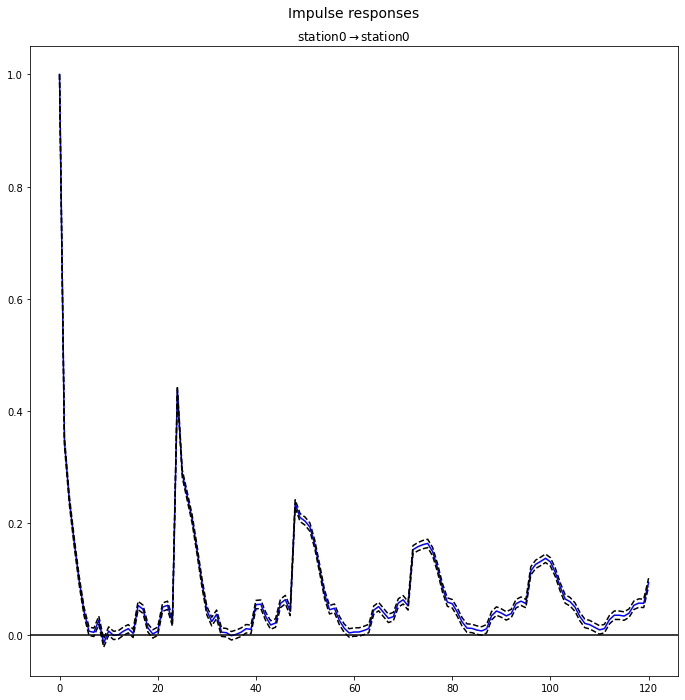

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station0', response = 'station0')
plt.show()

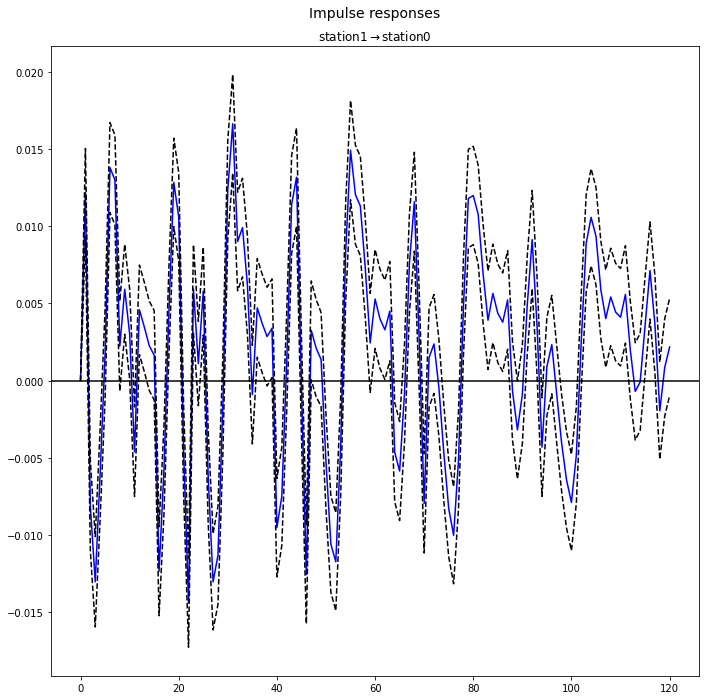

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station1', response = 'station0')
plt.show()

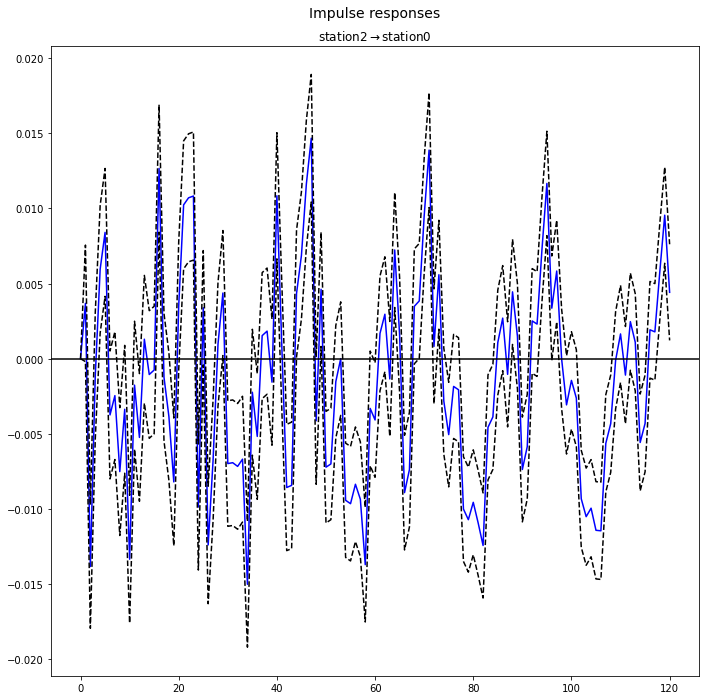

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station2', response = 'station0')
plt.show()

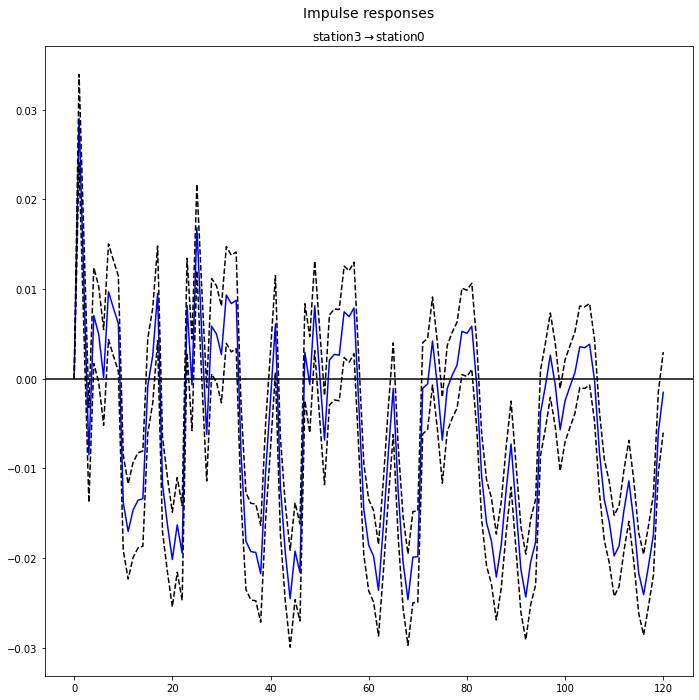

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station3', response = 'station0')
plt.show()

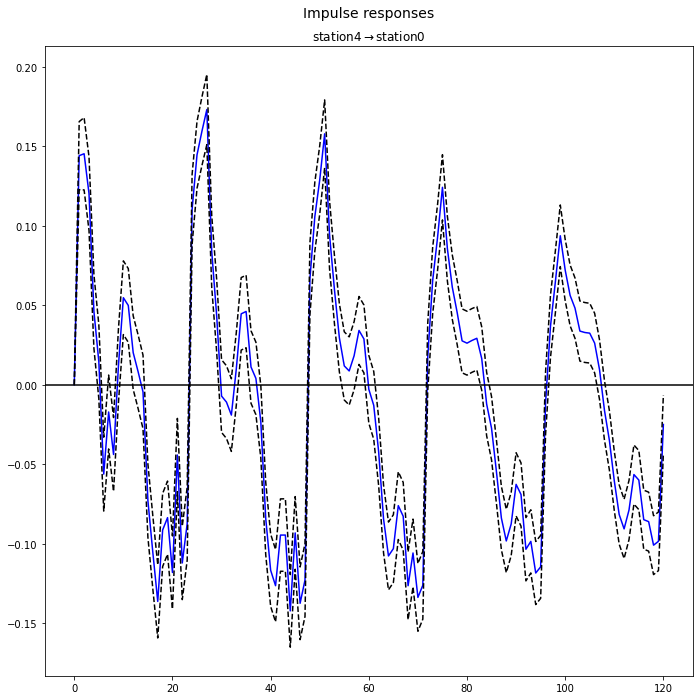

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station4', response = 'station0')
plt.show()

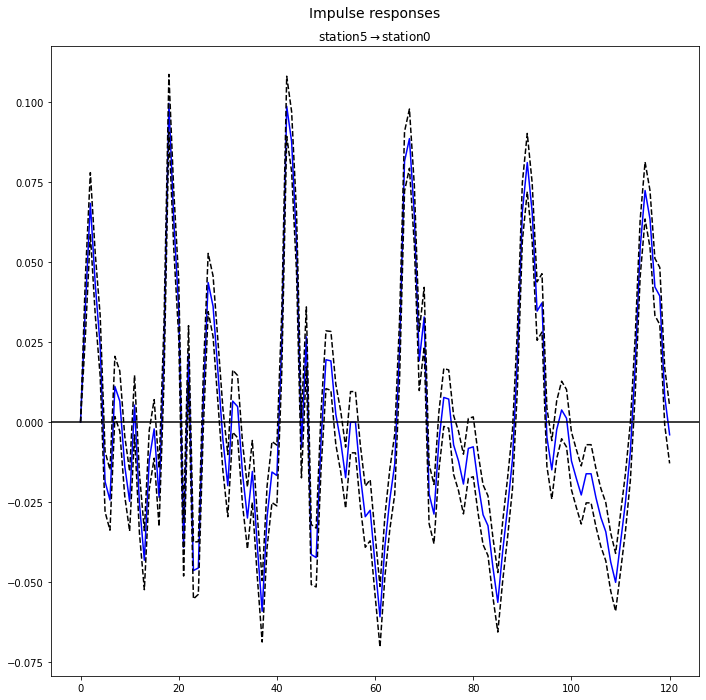

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station5', response = 'station0')
plt.show()

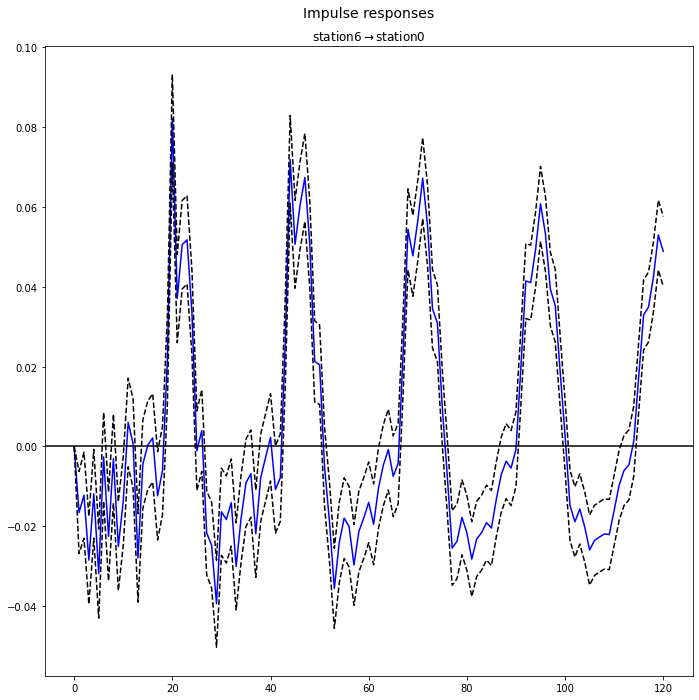

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station6', response = 'station0')
plt.show()

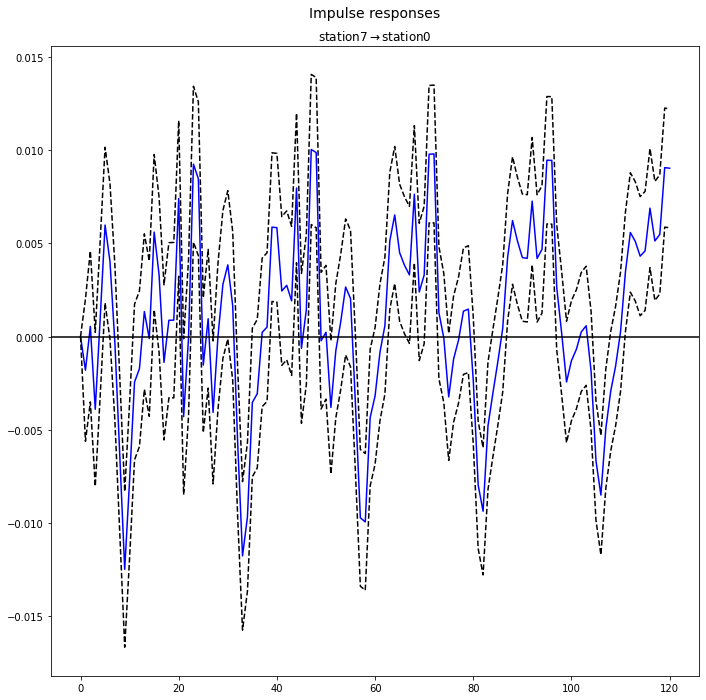

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station7', response = 'station0')
plt.show()

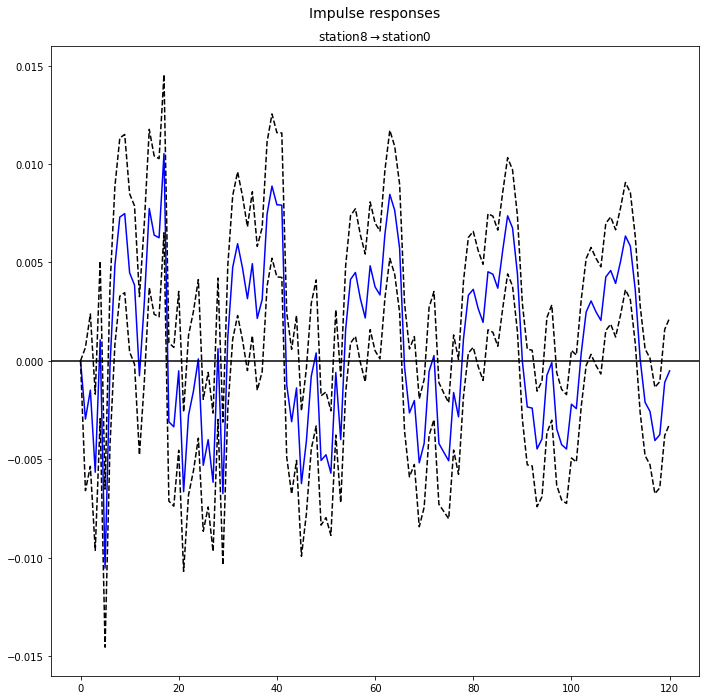

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'station8', response = 'station0')
plt.show()

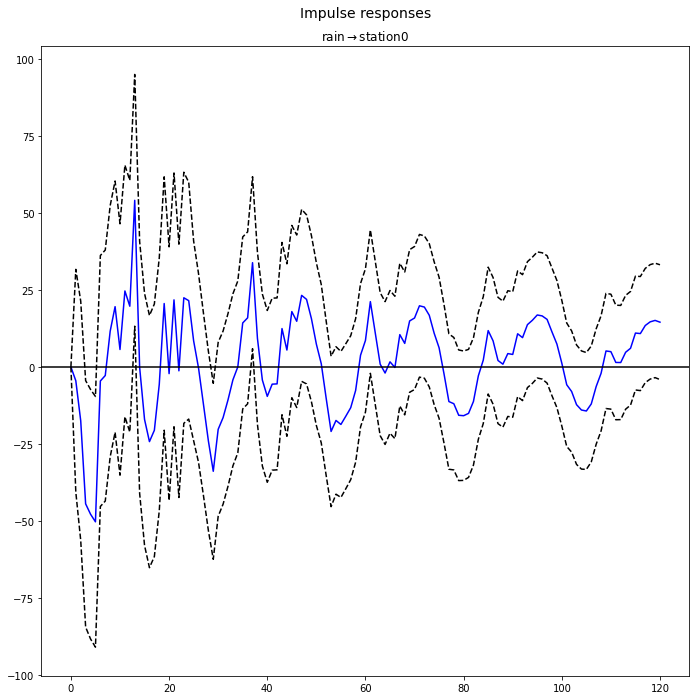

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'rain', response = 'station0')
plt.show()

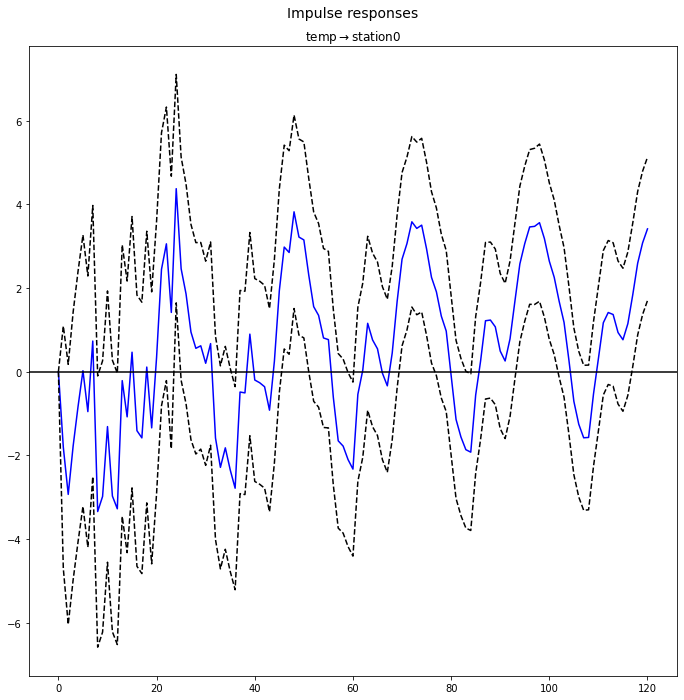

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'temp', response = 'station0')
plt.show()

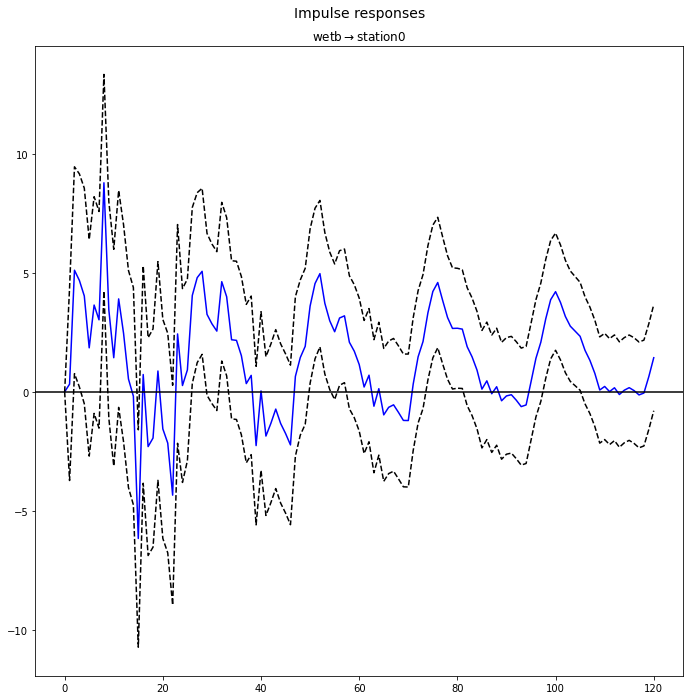

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'wetb', response = 'station0')
plt.show()

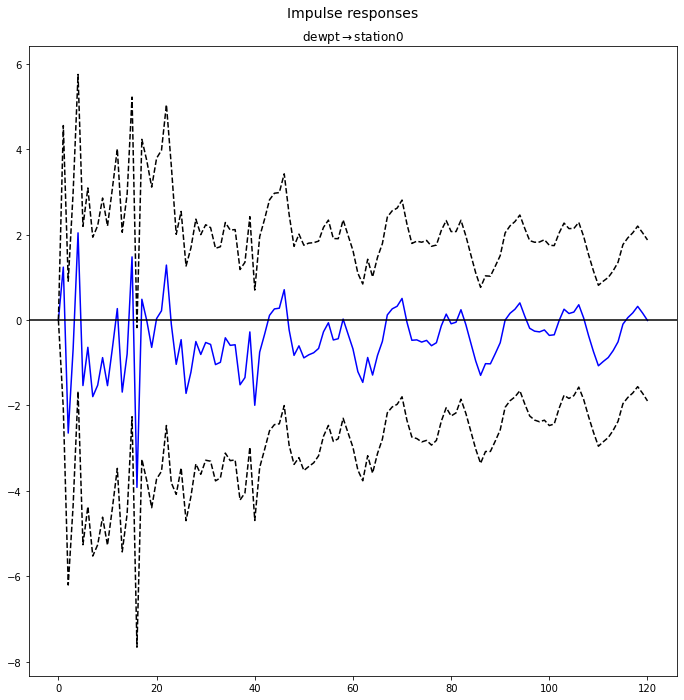

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'dewpt', response = 'station0')
plt.show()

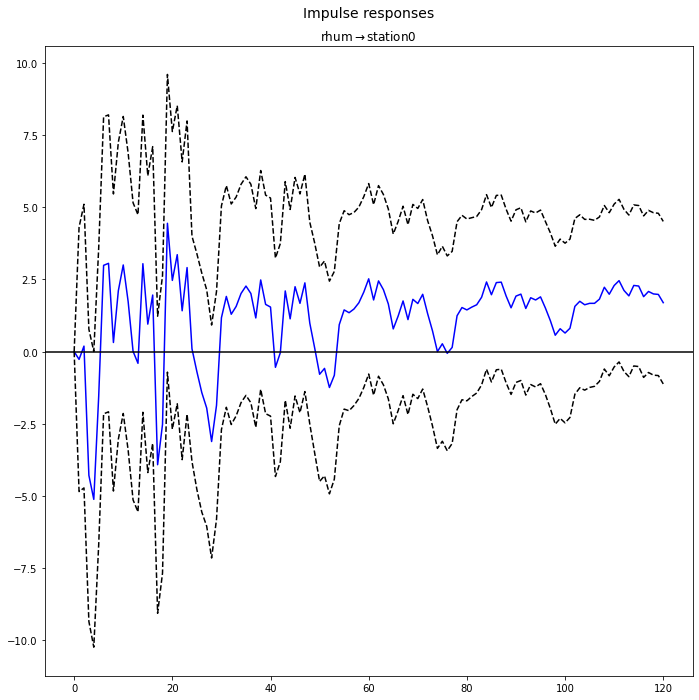

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'rhum', response = 'station0')
plt.show()

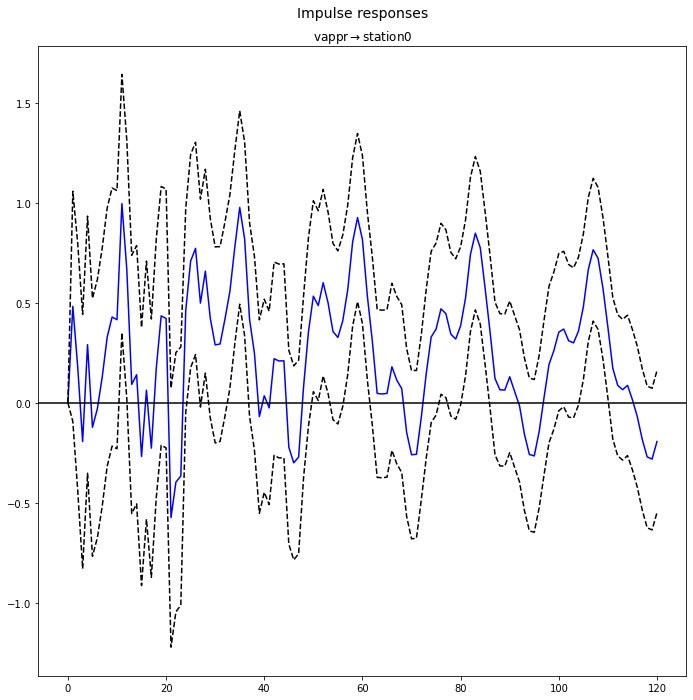

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'vappr', response = 'station0')
plt.show()

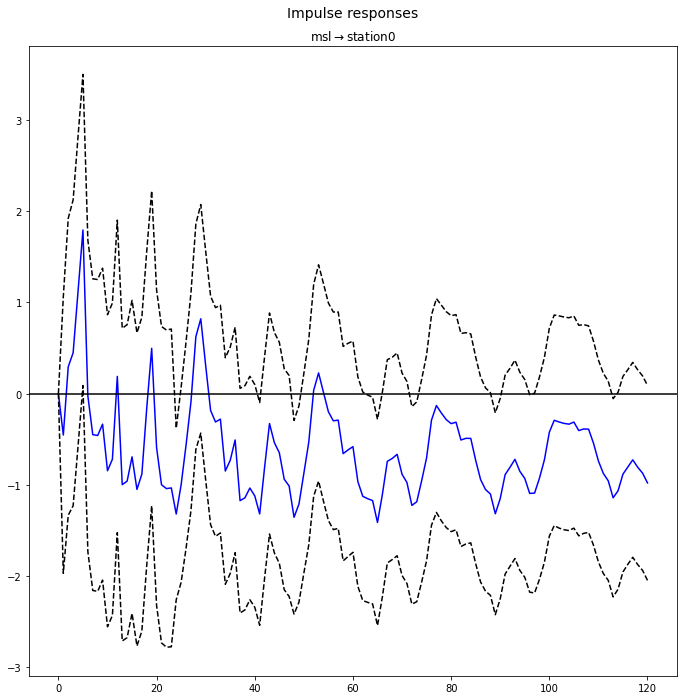

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'msl', response = 'station0')
plt.show()

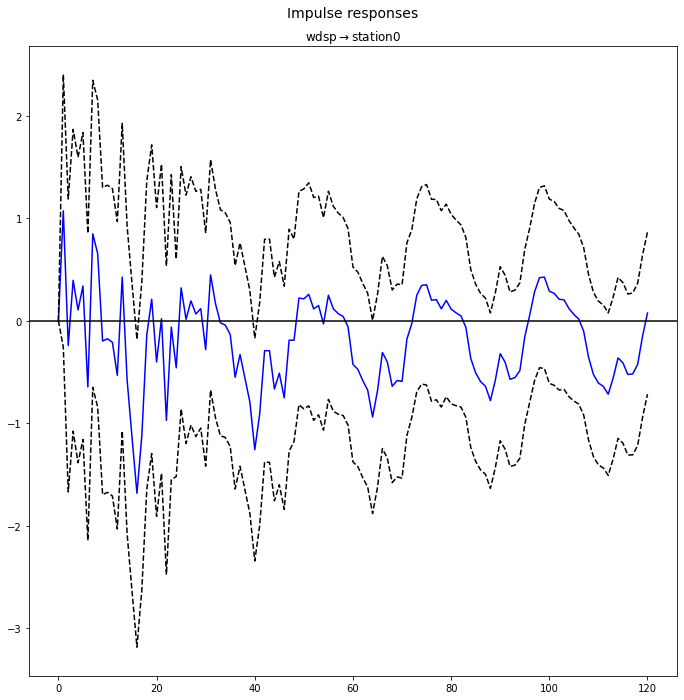

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'wdsp', response = 'station0')
plt.show()

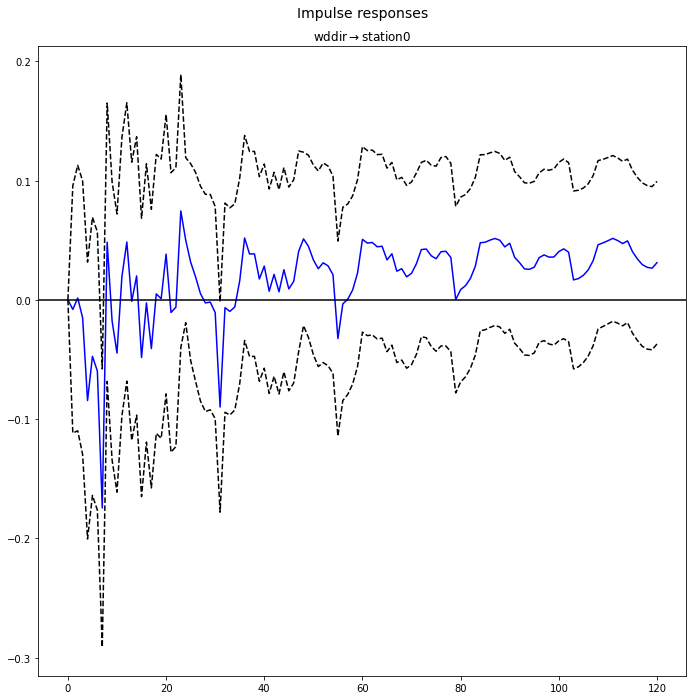

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'wddir', response = 'station0')
plt.show()

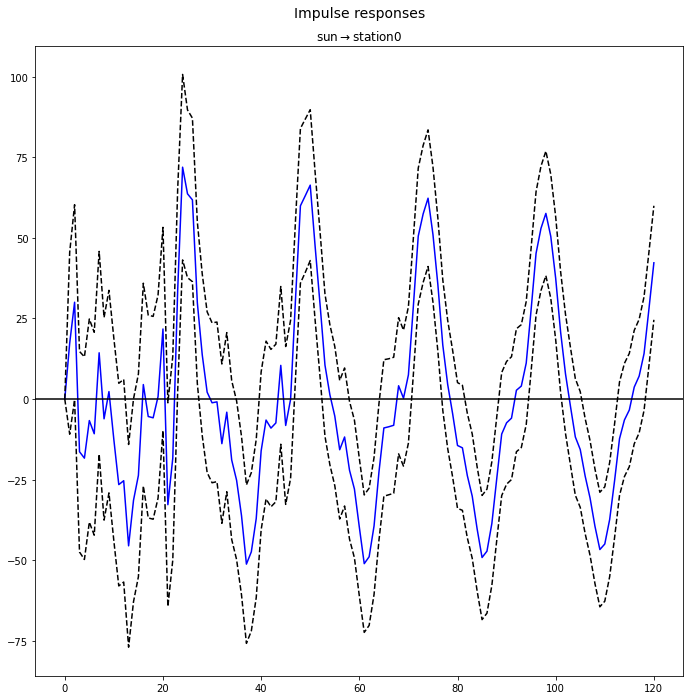

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'sun', response = 'station0')
plt.show()

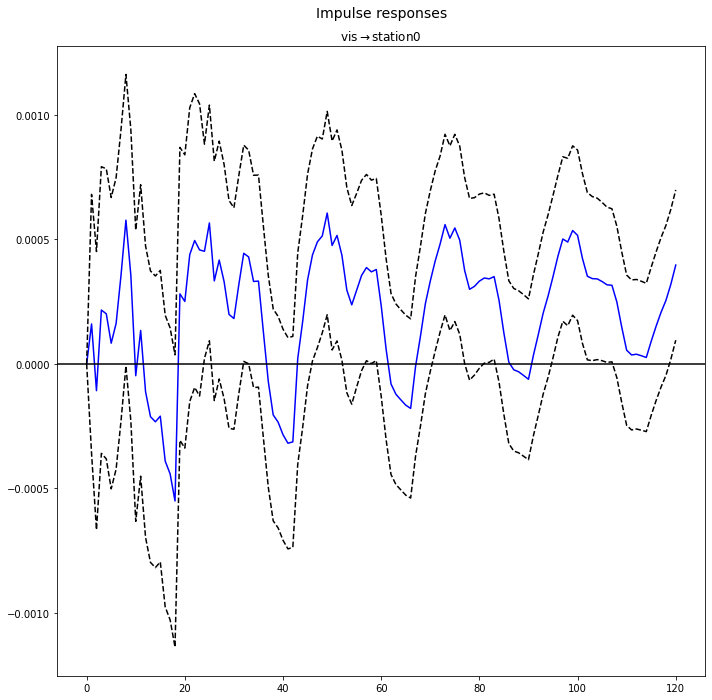

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'vis', response = 'station0')
plt.show()

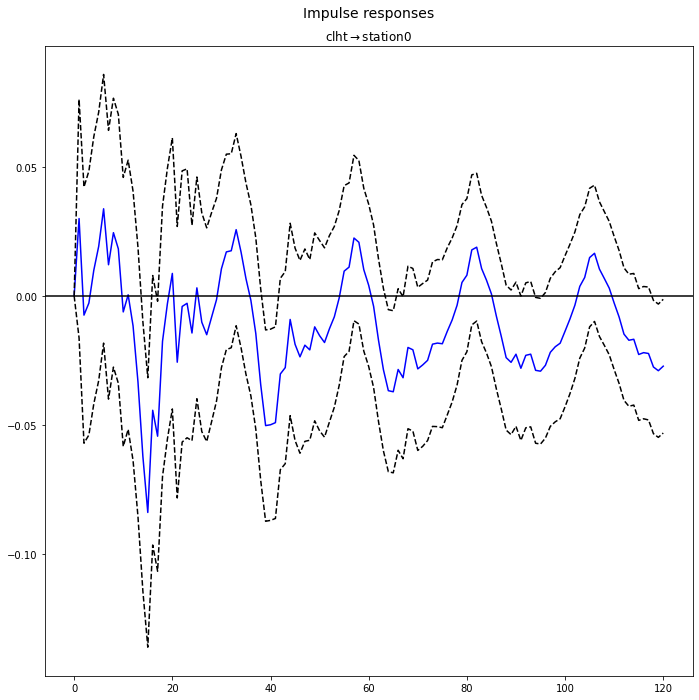

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'clht', response = 'station0')
plt.show()

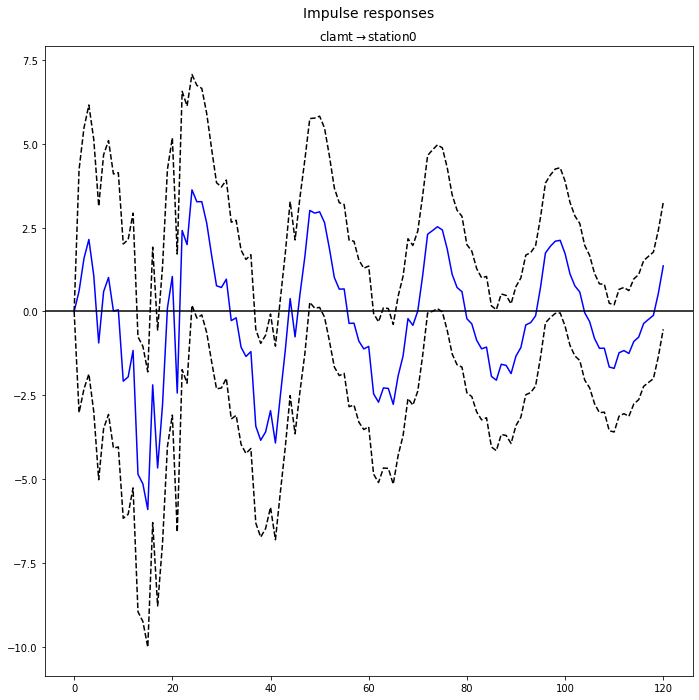

In [ ]:
irf_analysis = fitted_model.irf(periods = 120)
irf_analysis.plot(impulse = 'clamt', response = 'station0')
plt.show()

## Variance Decomposition

In [ ]:
fevd = fitted_model.fevd(240)
fevd.summary()

FEVD for station0
       station0  station1  station2  station3  station4  station5  station6  station7  station8      rain      temp      wetb     dewpt      rhum     vappr       msl      wdsp     wddir       sun       vis      clht     clamt
0      1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1      0.990447  0.003264  0.001055  0.002081  0.002259  0.000531  0.000120  0.000068  0.000030  0.000000  0.000024  0.000003  0.000007  0.000000  0.000027  0.000005  0.000030  0.000000  0.000020  0.000006  0.000021  0.000001
2      0.985449  0.003083  0.001008  0.002492  0.004787  0.002600  0.000174  0.000065  0.000035  0.000007  0.000029  0.000055  0.000037  0.000001  0.000030  0.000006  0.000030  0.000000  0.000063  0.000008  0.000031  0.000010
3      0.981521  0.004196  0.001058  0.002583  0.006038  0.003124  0.000494  0